In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import activations
import matplotlib.pyplot as plt
import time
import copy
import os

from IPython import display

In [ ]:
(training_set), dataset_info = tfds.load(
    'tf_flowers',
    split='train',
    with_info=True,
    as_supervised=True,
)

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

255 0


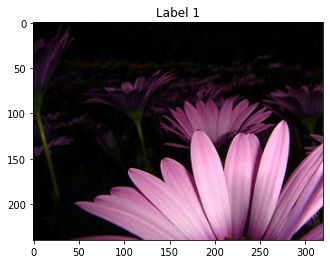

In [ ]:
for image, label in training_set.take(10):
    continue
image = image.numpy()
print(image.max(), image.min())
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.grid(False)
plt.show()

In [ ]:
img_width, img_height = 64,64
resize_rescale = tf.keras.Sequential([
          layers.experimental.preprocessing.Resizing(img_width, img_height),
          layers.experimental.preprocessing.Rescaling(1./255)
])

data_aug = tf.keras.Sequential([
   layers.experimental.preprocessing.RandomFlip("horizontal"),
   layers.experimental.preprocessing.RandomRotation(0.1),
 ])

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [ ]:
def augment(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [64, 64])
  image = (image / 255.0)
  return image, label

new_training_set = training_set.shuffle(BUFFER_SIZE, seed=42).map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True,).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(training_set)

3670

In [ ]:
def make_generator_model():
    filterSize = 4
    numFilters = 64
    numLatentInputs = 100

    model = tf.keras.Sequential()
    model.add(layers.Dense(4 * 4 * 512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))

    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(numFilters * 4, (filterSize, filterSize), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, numFilters * 4)
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))

    model.add(layers.Conv2DTranspose(numFilters * 2, (filterSize, filterSize), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, numFilters * 2)
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))

    model.add(layers.Conv2DTranspose(numFilters, (filterSize, filterSize), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, numFilters)
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))

    model.add(layers.Conv2DTranspose(3, (filterSize, filterSize), strides=2, padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Activation(activations.tanh))
    assert model.output_shape == (None, 64, 64, 3)

    return model

0.5092759 0.4915311


(-0.5, 63.5, 63.5, -0.5)

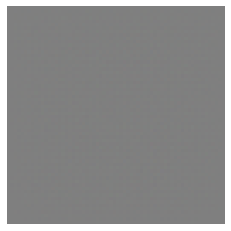

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image = (generated_image.numpy() / 2) + 0.5
print(generated_image.max(), generated_image.min())
plt.imshow(generated_image[0])
plt.axis('off')

In [ ]:
def make_discriminator_model():
    dropout_prob = 0.5
    num_filters = 64
    scale = 0.2

    input_size = [64, 64, 3]
    filter_size = 5

    model = tf.keras.Sequential()
    model.add(layers.Dropout(dropout_prob))
    model.add(layers.Conv2D(num_filters, (filter_size, filter_size), strides=2, padding='same', input_shape=input_size))
    model.add(layers.LeakyReLU(scale))

    model.add(layers.Conv2D(num_filters * 2, (filter_size, filter_size), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(scale))

    model.add(layers.Conv2D(num_filters * 4, (filter_size, filter_size), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(scale))

    model.add(layers.Conv2D(num_filters * 8, (filter_size, filter_size), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(scale))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation(activations.sigmoid))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50046563]], shape=(1, 1), dtype=float32)


In [ ]:
def summarize_epoch(epoch, d_losses, g_losses):
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.show()
    plt.close()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    # real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    real_labels = tf.ones_like(real_output)
    real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
    real_loss = cross_entropy(real_labels, real_output)

    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# def generator_loss(fake_output):
#     gen_loss = -1. * tf.math.reduce_mean(fake_output)
#     return gen_loss

# def discriminator_loss(real_output, fake_output, gradient_penalty):
#     c_lambda = 10
#     loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
#     return loss

# def gradient_penalty(real, fake, epsilon):
#     mixed_images = real * epsilon + fake * (1 - epsilon)
#     # mixed_images = fake + epsilon * (real - fake)

#     with tf.GradientTape() as tape:
#         tape.watch(mixed_images)
#         mixed_scores = discriminator(mixed_images, training=True)

#     gradient = tape.gradient(mixed_scores, mixed_images)[0]

#     gradient_norm = tf.norm(gradient)
#     penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
#     return penalty

In [ ]:
gen_learn_rate = 0.0002
disc_learn_rate = 0.0001

generator_optimizer = tf.keras.optimizers.Adam(gen_learn_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learn_rate)

disc_writer = tf.summary.create_file_writer('logs/disc/')
gen_writer = tf.summary.create_file_writer('logs/gen/')

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 3000
noise_dim = 100
num_examples_to_generate = 25
flip_prob = 0.15

seed = tf.random.normal([num_examples_to_generate, noise_dim])
fake_dataset = tf.random.normal([len(training_set), noise_dim])

In [ ]:
# noise = tf.random.normal([BATCH_SIZE, noise_dim])
# generated_images = generator(noise, training=True)
# print(generated_images)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images[0], training=True)
      fake_output = discriminator(generated_images, training=True)

      # epsilon = tf.random.normal([BATCH_SIZE, 1, 1, 1], 0.0, 1.0)
      # gp = gradient_penalty(images[0], generated_images, epsilon)

      flips = tf.constant(np.random.choice([0, 1], size=real_output.shape[0], p=[1 - flip_prob, flip_prob]), shape=real_output.shape, dtype=tf.float32)
      real_output = tf.abs(tf.subtract(real_output, flips))

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      # disc_loss = discriminator_loss(real_output, fake_output, gp)
      # gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# @tf.function
# def train_step(images):
#     noise = tf.random.normal([BATCH_SIZE, noise_dim])

#     #training discriminator 3 times for each batch
#     for i in range(3):

#       with tf.GradientTape() as disc_tape:

#         generated_images = generator(noise, training=True)

#         real_output = discriminator(images[0], training=True)
#         fake_output = discriminator(generated_images, training=True)
#         #print(np.shape(real_output))
#         #print(np.shape(fake_output))
#         epsilon = tf.random.normal([BATCH_SIZE, 1, 1, 1], 0.0, 1.0)
#         #print(np.shape(epsilon))
#         gp = gradient_penalty(images[0], generated_images, epsilon)

#         disc_loss = discriminator_loss(real_output, fake_output, gp)


#       gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#       discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#     with tf.GradientTape() as gen_tape:
#       generated_images = generator(noise, training=True)
#       fake_output = discriminator(generated_images, training=True)
#       gen_loss = generator_loss(fake_output)
#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

#     return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  d_losses = []
  g_losses = []

  for epoch in range(epochs):
    start = time.time()

    real_counts = 0
    fake_counts = 0

    for image_batch in dataset:
      real_output = discriminator(image_batch[0], training=False)
      real_counts += np.count_nonzero(np.array(real_output) > 0.5)

      d_loss, g_loss = train_step(image_batch)
      d_losses.append(d_loss)
      g_losses.append(g_loss)

    fake_images = generator(fake_dataset, training=False)
    fake_output = discriminator(fake_images, training=False)
    fake_counts = np.count_nonzero(np.array(fake_output) <= 0.5)

    with disc_writer.as_default():
      tf.summary.scalar('Loss', d_loss, step=epoch)
    with gen_writer.as_default():
      tf.summary.scalar('Loss', g_loss, step=epoch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    print(f'real acc: {real_counts / len(training_set)}')
    print(f'fake acc: {fake_counts / len(training_set)}')
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    summarize_epoch(epoch, d_losses, g_losses)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  print(f'real acc: {real_counts / len(training_set)}')
  print(f'fake acc: {fake_counts / len(training_set)}')
  generate_and_save_images(generator,
                           epochs,
                           seed)

  summarize_epoch(epoch, d_losses, g_losses)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7, 7))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype(int))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

real acc: 0.8332425068119891
fake acc: 0.2615803814713896


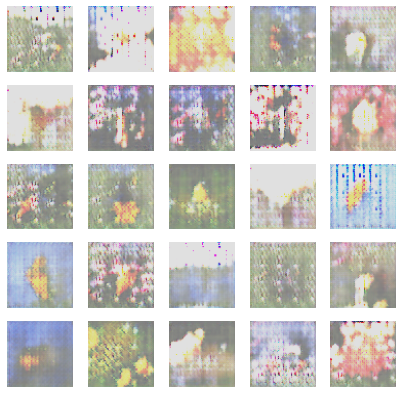

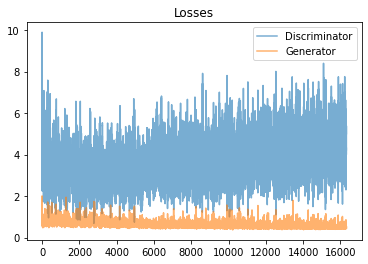

Time for epoch 583 is 12.8528733253479 sec


KeyboardInterrupt: ignored

In [ ]:
train(new_training_set, EPOCHS)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image = (generated_image.numpy() / 2) + 0.5
print(generated_image.max(), generated_image.min())
plt.imshow(generated_image[0])
plt.axis('off')